In [1]:
# !pip install pip --upgrade
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pandas as pd
# !pip install pyopenssl --upgrade
# !pip install --upgrade smart_open
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# for processing
import re
import nltk
from nltk.tokenize import word_tokenize


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

from datetime import datetime
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd

In [2]:
%%time
embeddings_dict_6B_50D = {}
with open("glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-50]).lower().strip()
        vector = np.asarray(values[-50:], "float32")
        embeddings_dict_6B_50D[word] = vector
        
def vectorize_text_50(text):
    vectors = [embeddings_dict_6B_50D.get(word) for word in str(text).split() if word in embeddings_dict_6B_50D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(50)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 3.83 s


In [3]:
%%time
embeddings_dict_6B_100D = {}
with open("glove.6B/glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-100]).lower().strip()
        vector = np.asarray(values[-100:], "float32")
        embeddings_dict_6B_100D[word] = vector
        
def vectorize_text_100(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized

Wall time: 7.55 s


In [4]:
def text_normalizer(text):
    if text:
        # Use NLTK RegexpTokenizer for tokenization. 
        # This tokenizer splits the text by white space and also keeps tokens like "wasn't" and "don't".
        tokenizer = RegexpTokenizer(r'\b\w[\w\'-]*\w\b|\w')
        words = tokenizer.tokenize(text)

        # Clean up any token with repeating characters like '666', 'aaa', '!!!!!!', substitute them with empty string ''.
        # This includes 'XXXX' maskings in the text created by CFPB.
        words = [re.sub(r'(\w)\1{2,}', '', word) if re.search(r'(\w)\1{2,}', word) else word for word in words]

        # Convert to lowercase and remove punctuations.
        words = [word.lower().strip() for word in words]

        # Substitute the tokens with "" where they are just numbers.
        words = ['' if word.isdigit() else word for word in words]

        # Join the words back into a single string.
        text = ' '.join([word for word in words if word])
    
    return text

In [5]:
%%time
cfpb_df = pd.read_csv("CFPB with Duplicate Marked NEW.csv")
print(cfpb_df.shape)

<timed exec>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


(1300361, 24)
Wall time: 23.7 s


In [6]:
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1083240, 24)


<AxesSubplot:ylabel='Frequency'>

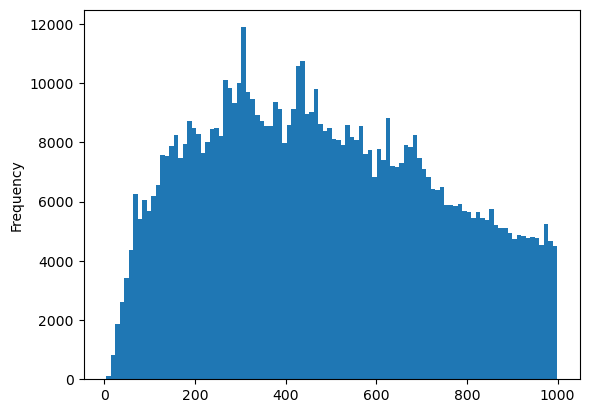

In [7]:
cfpb_df[cfpb_df['narr_len']<1000]['narr_len'].plot(kind='hist', bins=100) 

In [8]:
cfpb_df[(cfpb_df['narr_len']<300)&(cfpb_df['narr_len']>200)].sample(10)[['Consumer complaint narrative','Product']]

,Consumer complaint narrative,Product
1257518,I disputed this information because this was not my debt. I contacted XXXX XXXX services and I have a XXXX balance. This belongs to XXXX XXXX. The incorrect debt was removed from my credit on XXXX XXXX 2016. I recently just saw that this debt has been reinserted after it was deleted on XXXX XXXX,Credit reporting
742196,"I was affected by the Tornado that struck my place of employment ( XXXX ), which resulted in financial hardship and caused late payments. XXXX XXXX XXXX Please remove these late payments from my account due to natural disaster.","Credit reporting, credit repair services, or other personal consumer reports"
663739,"On XX/XX/XXXX, my account was compromised. Someone sent themselves {$410.00} & {$580.00} 2 transactions. The name was XXXX XXXX. \nThis was not authorized by myself, I realized this a day later, when I was trying to remove money from an atm.",Credit card or prepaid card
181044,Blackhawk XXXX gift card. An on-line merchant employee took card info during a purchase and attempted several transactions. XXXX succeeded ; XXXX XXXX XXXX for {$250.00}. Blackhawk says it was a valid transaction and refuses to return the money to me.,Prepaid card
191037,Every time I tried to open a checking accounts it automatically declines and sends them to XXXX XXXX XXXX but they don't resolve nothing and I want to know why is this happening and what can I do from my part to resolve it.,Checking or savings account
612497,"on XXXX XXXX, I sent a letter to the credit bureaus requesting an investigation on 5 accounts. Almost 60 days later, and none of them have responded. I have sent follow-up letters to inquire for the reason for the delay, and those have also gone unanswered.","Credit reporting, credit repair services, or other personal consumer reports"
936335,This company posted a debt to my credit report that is not correct and should not have been reported. I disputed the debt and they still chose to post to my report. No phone call or nothing. By law I have the right to dispute a debt. \nI never lived in the apartments they claim I owe money too.,Debt collection
396042,This account was bought out by XXXX XXXX XXXX and was paid and closed. Santander is still showing on my credit report even after XXXX bought the account and stopped reporting the account. I have contacted santander by phone and email to remove the account from reporting to the credit bureaus,Debt collection
89654,I have several items on my credit report that are not mine. I noticed it because I recently applied for a credit card and I wasnt approved so it prompts me to check my credit report. These items listed are not mine and need to be removed. USDDEPTOFEDXXXX XXXX {$1400.00},"Credit reporting, credit repair services, or other personal consumer reports"
764605,"I used XXXX service to send the funds and receive the item from the person but it was a fraud and I was ripped off. \nI immediately called my bank ( Chase ) and I was told once the money has been delivered, they can't do anything about it.","Money transfer, virtual currency, or money service"


In [9]:
cfpb_df['narr_len'].quantile(.16)

274.0

In [10]:
cfpb_df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'clean_narr', 'dupi_id', 'dupi_len'],
      dtype='object')

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

In [12]:
# Step 1: Calculate the relative frequency of each class
class_counts = cfpb_df['Issue'].value_counts(normalize=True)

# Step 2: Filter classes that occur more than 1% of the time
frequent_classes = class_counts[class_counts > 0.01].index

# Step 3: Filter the DataFrame to only include rows with these classes
filtered_df = cfpb_df[(cfpb_df['Issue'].isin(frequent_classes))&(cfpb_df['narr_len']>500)]

# Step 4: Encode the labels of these classes
label_encoder = LabelEncoder()
filtered_df['Issue_encoded'] = label_encoder.fit_transform(filtered_df['Issue'])

C:\Users\JYM\AppData\Local\Temp/ipykernel_57172/3601546177.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Issue_encoded'] = label_encoder.fit_transform(filtered_df['Issue'])


In [13]:
filtered_df['Issue'].value_counts(normalize=True)

Incorrect information on your report                                                0.234866
Problem with a credit reporting company's investigation into an existing problem    0.172824
Improper use of your report                                                         0.087281
Attempts to collect debt not owed                                                   0.081599
Trouble during payment process                                                      0.057706
Managing an account                                                                 0.055653
Problem with a purchase shown on your statement                                     0.038323
Written notification about debt                                                     0.033224
Struggling to pay mortgage                                                          0.029028
False statements or representation                                                  0.026486
Dealing with your lender or servicer                                  

In [14]:
# Prepare features and target variable

def vectorize_text_100(text):
    vectors = [embeddings_dict_6B_100D.get(word) for word in str(text).split() if word in embeddings_dict_6B_100D]
    vectors = [v for v in vectors if v is not None]  # remove any None values
    if vectors:
        vectorized = np.mean(vectors, axis=0)
    else:
        vectorized = np.zeros(100)  # if there are no vectors, return a zero-vector
    return vectorized
# vectorize
filtered_df['glove_50_features'] = filtered_df['clean_narr'].apply(vectorize_text_100)

# create x and y
X = list(filtered_df['glove_50_features'])
y = filtered_df['Issue_encoded']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

C:\Users\JYM\AppData\Local\Temp/ipykernel_57172/761405647.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['glove_50_features'] = filtered_df['clean_narr'].apply(vectorize_text_100)


In [15]:
# Apply Balancing with ADASYN
# ada = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = ada.fit_resample(np.array(X_train).tolist(), y_train)
# rus = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)

# Reset indices
X_train_resampled = np.array(X_train).tolist()
y_train_resampled = y_train.tolist()

In [16]:
# for data_size in [10000, 20000, 30000, 40000, 50000]:
# for data_size in [20000, 30000, 40000, 50000]:
# for data_size in [50000, 100000, 150000]:
for data_size in [200000]:
    # Randomly select x samples for training
    sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
    X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
    y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

    # grid search
    # param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [5,10,20]}
    # first round
    param_grid = {
        'n_estimators': [100, 200, 300], 
        'max_depth': [10, 25, 50], 
        'min_samples_split': [5, 10],
        'bootstrap': [True],
        'max_features': ['sqrt', 'log2']
    } # best {'bootstrap': True, 'max_depth': 25,50 'max_features': 'log2''sqrt', 'min_samples_split': 10, 'n_estimators': 200,300} [0.427, 0.455, 0.466...]
    
    # second run
    param_grid = {
        'n_estimators': [100],# , 200, 300], 
        'max_depth': [25], #50, 75], 
        'min_samples_split': [10],# 5, 15],
        'bootstrap': [True],
        'class_weight': ['balanced'],#,None],
        'max_features': [0.25],#0.30],
        'max_samples': [0.25]#[0.1, 0.3,0.4]
    } 

    # initialize random forest and grid
    rf = RandomForestClassifier(n_jobs=-1)
    grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', verbose=4, n_jobs=-1)
    # fitting the grid
    grid.fit(np.array(X_train_resampled_sampled).tolist(), y_train_resampled_sampled)

    # evaluate
    y_pred = grid.predict(np.array(X_test).tolist())
    print(f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred))
    print("The best parameters:", grid.best_params_)
    print("Data size:", data_size)

    results = grid.cv_results_
    for mean_test_score, params in zip(results["mean_test_score"], results["params"]):
        print(params, "has a score of", mean_test_score)
    print("-----------------------------------------------------------------------")
print("**************************************************************************")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.48621720220425785
              precision    recall  f1-score   support

           0       0.35      0.40      0.38      4110
           1       0.33      0.57      0.42      1014
           2       0.22      0.07      0.10       861
           3       0.52      0.56      0.54      1326
           4       0.23      0.09      0.12      1348
           5       0.49      0.23      0.31       885
           6       0.75      0.61      0.67      4443
           7       0.42      0.04      0.08       932
           8       0.61      0.60      0.60     11799
           9       0.26      0.14      0.19      1173
          10       0.45      0.72      0.55      2805
          11       0.31      0.28      0.30       872
          12       0.45      0.24      0.31       923
          13       0.62      0.59      0.60      8833
          14       0.41      0.55      0.47      1910
          15       0.45      0.52      0.48      1490
  

In [17]:
%%time
# train the model:
rf = RandomForestClassifier(bootstrap=True, class_weight= 'balanced', max_depth=25, max_features=0.25, max_samples=0.25, min_samples_split=10, n_estimators=100, n_jobs=-1)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X_train).tolist(), y_train)
# sample_idx = np.random.choice(len(X_train_resampled), data_size, replace=False)
# X_train_resampled_sampled = [X_train_resampled[i] for i in sample_idx]
# y_train_resampled_sampled = [y_train_resampled[i] for i in sample_idx]

rf.fit(np.array(X_train_resampled).tolist(), y_train_resampled)

y_pred = rf.predict(np.array(X_test).tolist())
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

0.4444018412079182
              precision    recall  f1-score   support

           0       0.45      0.19      0.26      4110
           1       0.29      0.63      0.40      1014
           2       0.13      0.24      0.17       861
           3       0.43      0.64      0.52      1326
           4       0.21      0.13      0.16      1348
           5       0.29      0.55      0.38       885
           6       0.62      0.65      0.64      4443
           7       0.10      0.54      0.17       932
           8       0.77      0.36      0.50     11799
           9       0.21      0.38      0.27      1173
          10       0.58      0.52      0.55      2805
          11       0.21      0.46      0.28       872
          12       0.23      0.43      0.30       923
          13       0.65      0.47      0.55      8833
          14       0.41      0.55      0.47      1910
          15       0.40      0.59      0.48      1490
          16       0.18      0.21      0.19      1155
        

In [19]:
import pickle
# Save each model
with open("issue_rf_model.pkl", 'wb') as file:
    pickle.dump(rf, file)